# Soil Water Content Planetary Variables from Planet Subscriptions API to Cloud Delivery

The Subscriptions API supports delivery to several cloud storage. This example uses the Subscription API to deliver Planet's Soil Water Content Planetary Variables to [Google Cloud Storage](https://static.prod.planet-labs.com/devcenter/dev/rel-pv-eap/docs/subscriptions/delivery/#delivery-to-google-cloud-storage).


Here you will set up a subscription to deliver Soil Water Content rasters to Google Cloud, retrieve CSV metadata to do a time series analysis on that data, then pick a significant result from that analysis and retrieve that raster data from the cloud to plot a final detail.


## Before you begin

Besides needing your API key, which you can retrieve from your [Planet Account page > My Settings](https://www.planet.com/account/?fromLogin=true#/user-settings), delivering and downloading from a cloud bucket requires several steps.

### Colab and Cloud Storage FUSE \[Alternative: Online Analysis\]

This example uses Google Cloud, which integrates nicely with Google Colab, so instead of locally downloading a Python client for Google Storage and authenticating against that (descrbed in the next section), you could open this notebook in Colab and [mount a Cloud Storage bucket using Cloud Storage FUSE](https://cloud.google.com/storage/docs/gcsfuse-quickstart-mount-bucket).

### Get data from your cloud bucket \[Described here: Local Analysis\]

You can use the [Python Client for Google Cloud Storage](https://cloud.google.com/python/docs/reference/storage/latest) to retrieve your data. Here, we import the storage feature from the `google.cloud` package. To do so, you need to download and install the client, and authenticate against the service as described in [Set up Application Default Credentials](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev). See the [Cloud Storage client libraries documentation](https://cloud.google.com/storage/docs/reference/libraries#client-libraries-install-python).

## Planet API Authentication

The Planet API uses Basic HTTP Authentication and requires that you have a Planet API key. Once you're signed up, you can find your API key in your [account settings](https://www.planet.com/account). Only one value is needed, so instead of using a username and password, you authenticate by setting `username` to your API key.

You could pass the API key as a variable in your code, but doing so makes it easy for others to see your key--not a good privacy and security practice. So the Python example, below, presumes you've stored your API key in a `.env` file at the root of your project.

You create a `.env` file and place your API string there:

```
PL_API_KEY = "[The API string from the My Settings section of your Planet Account page]"
```

Now, you are ready to pull your API key into your Python code without exposing it in the code. Assuming your Python file is in the same directory as your `.env` file, you import the dotenv package and call `dotenv_values(".env")`.

## Import packages and assign keys and cloud location

In [3]:
from dotenv import dotenv_values
from shapely.geometry import shape, MultiPolygon, Polygon, mapping
from shapely.ops import unary_union
from shapely import simplify, buffer

import requests
from requests.auth import HTTPBasicAuth
import json

import pandas as pd

from io import StringIO

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np

from dateutil.parser import parse

from google.cloud import storage
import os
from datetime import datetime


from google.api_core.exceptions import ServiceUnavailable, GatewayTimeout, BadGateway, InternalServerError, GoogleAPICallError
from retrying import retry

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
from matplotlib import patches

import geopandas as gpd


In [4]:
# Get your Planet API Key from an environment variable
DOT_ENV_VALS = dotenv_values(".env")

# Your Planet API Key 
API_KEY = DOT_ENV_VALS["PL_API_KEY"] 

# Your GCS project ID where your bucket is located
GCS_PROJECT_ID = DOT_ENV_VALS["GCPROJECTID"] 

# Your GCS bucket name that resides in the GCS project
GCS_BUCKET_NAME = DOT_ENV_VALS["GCSBUCKET"] 

# Your GCS service agent's JSON credentials that you Base64 encoded and stored in the .env file
GCS_CREDS_B64 = DOT_ENV_VALS["GCSCREDS"] 

# Planet's Subscriptions API base URL for making restFUL requests
BASE_URL = "https://api.planet.com/subscriptions/v1"

## Create a Subscription

### Validate your area of interest (AOI)

Depending on your account type, you may have different permissions for different products. For Subscriptions API, you must have access to a particular area of access (AOA). Your area of interest (AOI) must be within your area of access. The person at your organization who has set up your account can provide you with the geometries of the AOAs you have access to. Alternatively, you can confirm this AOA with your Planet CSM.

This example uses a simplified geometry of California to look at Soil Water Content for California's contiguous agricultural region. You will only be able to retrieve data from an area of access (AOA) to which you have been provisioned with Planet for a particular product. If your AOA does not include California, you can still review this excersize and apply it to an AOA you have access to, replacing the `AOI` and `AOA` values below with geometries of your AOI and AOA.

The following example uses [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) to compare the AOI with the AOA provisioned for you and returns `True` only if the `AOI` is within the `AOA`.

In [5]:
# Area of Interest (AOI) - California Agricultural Region
AOI = {
    "type": "Polygon",
    "coordinates": [ [ [ -120.035348813183262, 41.95037106697503 ],
                        [ -124.160827159620538, 41.987041985610027 ],
                        [ -123.665769758048071, 39.035033035492681 ],
                        [ -121.722211070393172, 36.871448836027795 ],
                        [ -121.868894744933158, 36.376391434455321 ],
                        [ -120.383722540215743, 34.579516421340415 ],
                        [ -117.945106450988376, 33.846098048640457 ],
                        [ -117.04666894443092, 32.910989623448003 ],
                        [ -117.028333485113421, 32.525944977780526 ],
                        [ -114.571381936568542, 32.76430594890801 ],
                        [ -114.204672750218563, 34.249478153625432 ],
                        [ -114.64472377383855, 34.982896526325398 ],
                        [ -119.998677894548265, 39.016697576175183 ],
                        [ -120.035348813183262, 41.95037106697503 ] ] ] }

# Area of Access (AOA) - US
AOA = {
    "type": "Polygon",
    "coordinates": [[[ -126.9504, 46.5531 ],
                        [ -54.1833, 46.7628 ],
                        [ -77.8798, 24.3246 ],
                        [ -94.6561, 23.9051 ],
                        [ -124.2242, 34.1806 ],
                        [ -126.9504, 46.5531 ]]]
      }

# Determine if the AOI is inside the AOA
def is_inside(AOI, AOA):
    smaller_shape = shape(AOI)
    larger_shape = shape(AOA)
    
    return smaller_shape.within(larger_shape)

print(is_inside(AOI, AOA))  # True


True


### Create a new Subscriptions JSON object

Now that you have confirmed your AOI is within your AOA, set up the parameters of what you want from the Planet service by describing your subscription in JSON format using the source of type `soil_water_content`.


In [6]:
# Create a new subscription JSON object
subscription_desc = {
   "name": "California Agricultural Region SWC-AMSR2-C_V4.0_1000",
   "source": {
       "type": "soil_water_content",
       "parameters": {
           "id": "SWC-AMSR2-C_V4.0_1000",
           "start_time": "2022-11-15T00:00:00Z",
           "end_time": "2023-05-15T00:00:00Z",
           "geometry": {
                   "coordinates": [ [ [ -120.035348813183262, 41.95037106697503 ],
                                        [ -124.160827159620538, 41.987041985610027 ],
                                        [ -123.665769758048071, 39.035033035492681 ],
                                        [ -121.722211070393172, 36.871448836027795 ],
                                        [ -121.868894744933158, 36.376391434455321 ],
                                        [ -120.383722540215743, 34.579516421340415 ],
                                        [ -117.945106450988376, 33.846098048640457 ],
                                        [ -117.04666894443092, 32.910989623448003 ],
                                        [ -117.028333485113421, 32.525944977780526 ],
                                        [ -114.571381936568542, 32.76430594890801 ],
                                        [ -114.204672750218563, 34.249478153625432 ],
                                        [ -114.64472377383855, 34.982896526325398 ],
                                        [ -119.998677894548265, 39.016697576175183 ],
                                        [ -120.035348813183262, 41.95037106697503 ] ] ],
               "type": "Polygon"
           }
       }
   },
   "delivery": {
        "type": "google_cloud_storage",
        "parameters": {
            "bucket": GCS_BUCKET_NAME,
            "credentials": GCS_CREDS_B64
        }
    }
}

### Subscribe to the data using your JSON subscription description object

This is where you make the request to Planet and receive your subscription ID.

Before you create the subscription, set up your `auth` request value by making a call to the service and receiving a `<response 200>` response.


In [7]:
# confirm that the API key is valid
auth = HTTPBasicAuth(API_KEY, '')
response = requests.get(BASE_URL, auth=auth)
response

<Response [200]>

In [13]:
# set content type to json
headers = {'content-type': 'application/json'}

# create a subscription
def subscribe_pv(subscription_desc, auth, headers):
    response = requests.post(BASE_URL, data=json.dumps(subscription_desc), auth=auth, headers=headers)
    print(response)
    subscription_id = response.json()['id']
    print(subscription_id)
    subscription_url = BASE_URL + '/' + subscription_id
    return subscription_url

pv_subscription = subscribe_pv(subscription_desc, auth, headers)

<Response [200]>
91224466-dac0-4649-a521-bf07a4698e46


## Using the data from Planet

### Get the subscription

When you receive the subscription ID, you can check that the subscription is in the `running` state. While you can use the data as it becomes available to start building your analysis, running the subscription may take a while depending on factors such as the size of your AOI and the time range.

Here we check the status of the subscription we created.

In [8]:
# Get the subscription ID - GCP bucket directory name where the data will be delivered
sub_id = requests.get(pv_subscription, auth=auth).json()['id']
# eg: sub_id = "3d4baf02-aca7-4e1d-b980-61564142f549"

# Use sub_id to get the subscription state
def get_sub_status(sub_id, auth):
    sub_url = BASE_URL + '/' + sub_id
    sub_status = requests.get(sub_url, auth=auth).json()['status']
    return sub_status

# Note: Running the subscription may take a while depending 
# on the size of your AOI and the time range.
sub_status = get_sub_status(sub_id, auth)
sub_status


'completed'

### Pull the CSV data from the subscription and analysis 

Use the pandas library to read the CSV data into a DataFrame called df. Only valid data is filtered and retained in the dataframe for further analysis or processing.

Next, you can retrieve data in CSV format from a specified URL using an API request. Then read the CSV data into a Pandas dataframe. Use `item_datetime` in a datetime format and removes the timezone information. You can filter the dataframe to include only rows where the month of `item_datetime` falls between November 15th and May 15th. You can also filter the dataframe to keep only rows with valid data, excluding any rows with null or zero values for `swc.band-1.valid_percent`, as well as rows with a status of `QUEUED`. You have the option to assign a title value to the dataframe from a subscription description. Finally, view the first few rows of the dataframe to examine the data.

Read more about the different state of [Subscription Status](https://developers.planet.com/docs/subscriptions/#subscription-status).

Read more about `valid_percent` in [Metadata Results (Time Series)](https://static.prod.planet-labs.com/devcenter/dev/rel-pv-eap/docs/subscriptions/pvs-subs/#metadata-results-time-series).

In [9]:
# Retrieve the resulting data in CSV format. 
resultsCSV = requests.get(f"{BASE_URL}/{sub_id}/results?format=csv", auth=auth)

# read the CSV data into a text file
with open('results.csv', 'w') as f:
    f.write(resultsCSV.text)

# Read the CSV file into a DataFrame
# df = pd.read_csv('results.csv')
df = pd.read_csv(StringIO(resultsCSV.text), parse_dates=["item_datetime", "local_solar_time"])

# Ensure 'item_datetime' is in datetime format and remove timezone
df['item_datetime'] = pd.to_datetime(df['item_datetime']).dt.tz_localize(None)

# Filter by valid data only
df = df[df["swc.band-1.valid_percent"].notnull()]
df = df[df["swc.band-1.valid_percent"] > 0]
df = df[df["status"] != 'QUEUED']

df.title = subscription_desc["name"]

df.head()


,id,item_datetime,status,created,updated,errors,outputs,item_id,local_solar_time,source_id,swc.band-1.mean,swc.band-1.valid_percent
0,ada8b862-3ced-4c34-b707-7218d32161fc,2022-11-15 09:30:00,SUCCESS,2023-05-25T22:24:39.762349Z,2023-05-25T22:25:17.639125Z,{},NaN,SWC-AMSR2-C_V4.0_1000_2022-11-15T0130,2022-11-15 01:30:00,SWC-AMSR2-C_V4.0_1000,144.12,46
1,47b89f5f-a5dd-40b3-a2df-bbd448d139ed,2022-11-16 09:30:00,SUCCESS,2023-05-25T22:25:06.277342Z,2023-05-25T22:25:37.935793Z,{},NaN,SWC-AMSR2-C_V4.0_1000_2022-11-16T0130,2022-11-16 01:30:00,SWC-AMSR2-C_V4.0_1000,144.18,93
2,d95e90eb-c624-49f0-8e36-6dfff780db07,2022-11-17 09:30:00,SUCCESS,2023-05-25T22:25:29.525245Z,2023-05-25T22:26:55.54376Z,{},NaN,SWC-AMSR2-C_V4.0_1000_2022-11-17T0130,2022-11-17 01:30:00,SWC-AMSR2-C_V4.0_1000,126.31,46
3,47b3194b-f118-422d-b09d-b67ca122aba5,2022-11-18 09:30:00,SUCCESS,2023-05-25T22:25:55.810801Z,2023-05-25T22:27:14.317079Z,{},NaN,SWC-AMSR2-C_V4.0_1000_2022-11-18T0130,2022-11-18 01:30:00,SWC-AMSR2-C_V4.0_1000,146.71,93
4,db265183-e643-48c0-a57d-3310ecf9420d,2022-11-19 09:30:00,SUCCESS,2023-05-25T22:26:25.089736Z,2023-05-25T22:28:30.154709Z,{},NaN,SWC-AMSR2-C_V4.0_1000_2022-11-19T0130,2022-11-19 01:30:00,SWC-AMSR2-C_V4.0_1000,118.02,67


Now plot the data from the filtered dataframe.


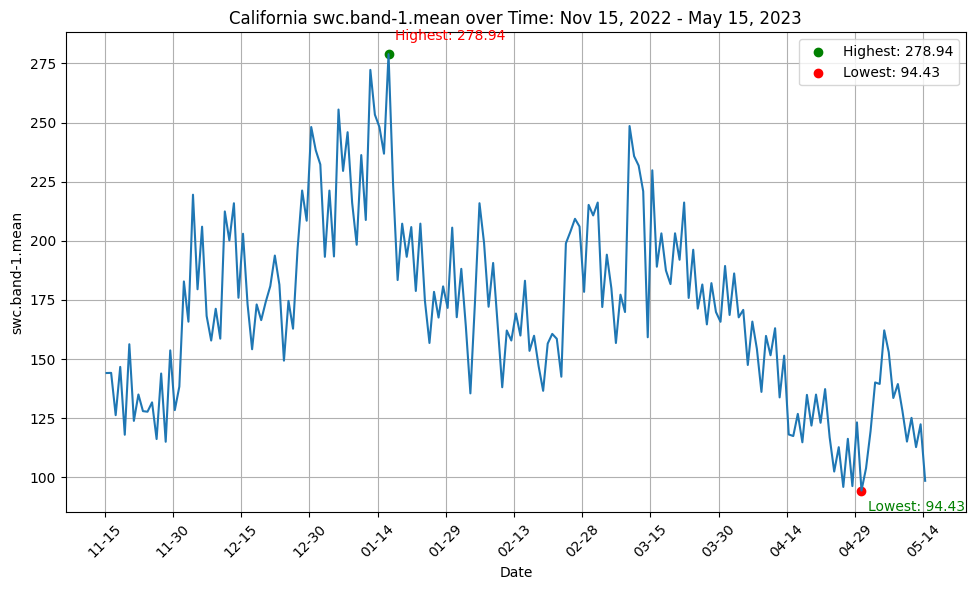

In [10]:
# Filter the data within the specified date range
start_date = pd.Timestamp('2022-11-15')
end_date = pd.Timestamp('2023-05-15')
filtered_df = df[(df['item_datetime'] >= start_date) & (df['item_datetime'] <= end_date)]

# Find the highest and lowest values
highest_value = filtered_df['swc.band-1.mean'].max()
lowest_value = filtered_df['swc.band-1.mean'].min()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(filtered_df['item_datetime'], filtered_df['swc.band-1.mean'])
ax.scatter(filtered_df.loc[filtered_df['swc.band-1.mean'] == highest_value, 'item_datetime'], highest_value, color='green', label=f'Highest: {highest_value:.2f}')
ax.scatter(filtered_df.loc[filtered_df['swc.band-1.mean'] == lowest_value, 'item_datetime'], lowest_value, color='red', label=f'Lowest: {lowest_value:.2f}')
ax.set_xlabel('Date')
ax.set_ylabel('swc.band-1.mean')
ax.set_title('California swc.band-1.mean over Time: Nov 15, 2022 - May 15, 2023')

# Format x-axis tick labels as MM-DD
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))

# Annotate highest value
ax.annotate(f'Highest: {highest_value:.2f}', xy=(filtered_df.loc[filtered_df['swc.band-1.mean'] == highest_value, 'item_datetime'], highest_value), xytext=(5, 10),
            textcoords='offset points', color='red')

# Annotate lowest value
ax.annotate(f'Lowest: {lowest_value:.2f}', xy=(filtered_df.loc[filtered_df['swc.band-1.mean'] == lowest_value, 'item_datetime'], lowest_value), xytext=(5, -15),
            textcoords='offset points', color='green')

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Print highest and lowest values with dates
highest_date = filtered_df.loc[filtered_df['swc.band-1.mean'] == highest_value, 'item_datetime'].iloc[0]
lowest_date = filtered_df.loc[filtered_df['swc.band-1.mean'] == lowest_value, 'item_datetime'].iloc[0]

print(f'Highest Value: {highest_value:.2f} on {highest_date.date()}')
print(f'Lowest Value: {lowest_value:.2f} on {lowest_date.date()}')


Highest Value: 278.94 on 2023-01-16
Lowest Value: 94.43 on 2023-04-30


## Getting the data from your cloud bucket

Now that we have the date of the highest value, we can retrieve that day's raster file from the cloud and plot the soil water content for that day. Remember this connection to Google Cloud requires you to have authenticated locally. For tips on how to do so, see *Get data from your cloud bucket \[Described here: Local Analysis\]*, above.

### The path to your data

The path to your data is made up of your GCP resource location, your bucket name, and the folder and file structure created by the Subscriptions API when it delivered the data.

### Retrieving the subscription's file path in GCS

In the code above, we already have used the values: GCS_BUCKET_NAME, GCS_KEY, and the subscription ID `sub_id`. Now we'll get the location of the data delivered to GCS.

In [12]:
# Use highest_date string to build the GCS folder name and destination directory
highest_date_str = datetime.strftime(highest_date.date(), "%Y/%m/%d")

GCS_FOLDER = f'{sub_id}/{highest_date_str}/'
DEST_DIR = f'./{sub_id}/{highest_date_str}/'

# Create the destination directory for the data to be downloaded
os.makedirs(DEST_DIR, exist_ok=True)


In [13]:
os.environ["GCLOUD_PROJECT"] = GCS_PROJECT_ID

In [14]:
def download_directory(bucket_name, source_directory_name, destination_directory_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    
    blobs = bucket.list_blobs(prefix=source_directory_name)  # Get list of files

    swc_files = []  # Empty list to store filenames that do not end with "-qf.tiff"

    for blob in blobs:
        filename = blob.name.replace('/', '_')  # Convert the blob name into a valid filename (optional)
        destination_filename = os.path.join(destination_directory_name, filename)

        # Now use the same download_to_filename method to download each individual file
        blob.download_to_filename(destination_filename)

        print(
            "Downloaded storage object {} from bucket {} to local file {}.".format(
                blob.name, bucket_name, destination_filename
            )
        )
        if not destination_filename.endswith("-qf.tiff"):
            swc_files.append(destination_filename)

    # Create variables dynamically for each filename that does not end with "-qf.tiff"
    for i, filename in enumerate(swc_files):
        exec("swc_file_{} = '{}'".format(i+1, filename))

    return swc_files


In [15]:
swc_data_files = download_directory(bucket_name=GCS_BUCKET_NAME, source_directory_name=GCS_FOLDER, destination_directory_name=DEST_DIR)

print(swc_data_files[0])

Downloaded storage object 3d4baf02-aca7-4e1d-b980-61564142f549/2023/01/16/SWC-AMSR2-C_V4.0_1000-20230116T0130_swc-qf.tiff from bucket jub-test-bucket to local file ./3d4baf02-aca7-4e1d-b980-61564142f549/2023/01/16/3d4baf02-aca7-4e1d-b980-61564142f549_2023_01_16_SWC-AMSR2-C_V4.0_1000-20230116T0130_swc-qf.tiff.
Downloaded storage object 3d4baf02-aca7-4e1d-b980-61564142f549/2023/01/16/SWC-AMSR2-C_V4.0_1000-20230116T0130_swc.tiff from bucket jub-test-bucket to local file ./3d4baf02-aca7-4e1d-b980-61564142f549/2023/01/16/3d4baf02-aca7-4e1d-b980-61564142f549_2023_01_16_SWC-AMSR2-C_V4.0_1000-20230116T0130_swc.tiff.
./3d4baf02-aca7-4e1d-b980-61564142f549/2023/01/16/3d4baf02-aca7-4e1d-b980-61564142f549_2023_01_16_SWC-AMSR2-C_V4.0_1000-20230116T0130_swc.tiff


## Plotting the raster data

The following example takes a file from the retrieved data and opens it in Rasterio.

In [16]:
file = swc_data_files[0]

swc_raster_data = []

with rasterio.open(file) as src:
    data = src.read(1, masked=True)
    swc_raster_data.append(data)


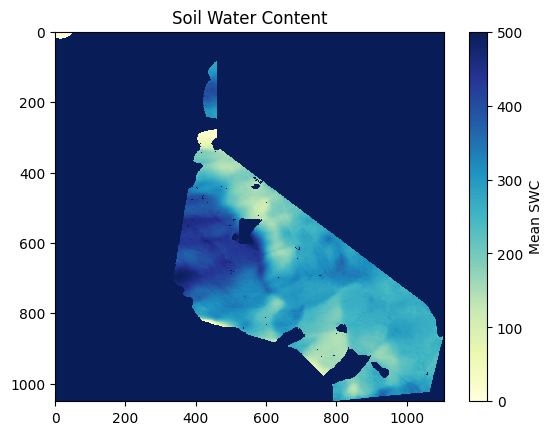

In [17]:
swc_raster_data = np.squeeze(swc_raster_data)  # Remove the first dimension

def plot_swc_raster_data(swc_raster_data):
    plt.imshow(swc_raster_data, cmap='YlGnBu', interpolation='none', vmin=0, vmax=500)
    plt.colorbar(label='Mean SWC')
    plt.title('Soil Water Content')
    plt.show()

plot_swc_raster_data(swc_raster_data)


You have now visualized soil water content from band 1 by removing extraneous dimensions from the data array and then generating a heatmap with a colorbar.